# Define some global variables

In [1]:
# set this to True before commiting
COMMIT = False

if COMMIT:
    upscaling_steps=13
    opt_steps=20
    verbose=1
    TOP = 4
else:
    upscaling_steps=2
    opt_steps=10
    verbose=2
    TOP = 1
    
INTERACTIVE = not COMMIT

# Import libraries

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
from torchvision import models, transforms
import cv2
import matplotlib.pyplot as plt
import zipfile
import PIL
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

/tmp/ipykernel_458581/3403579602.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# Load a trained CNN

In [3]:
# VGG19 BN
model = models.vgg19_bn()
model.load_state_dict(torch.load('vgg19_bn-c79401a0.pth'))
model.eval()
model = model.double()

In [4]:
# list cnn layers
layers = [layer for layer in model.children()]
print('Layers: {}'.format(len(layers)))
print('Layers[0]: {}'.format(len(layers[0])))
if INTERACTIVE:
    for l in layers:
        print(l)

Layers: 3
Layers[0]: 53
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU(inplace=True)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU(inplace=True)
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), str

In [5]:
device = torch.device("cpu")

# This class serves to hook cnn layers
We need to "see" what happens step per step, layer per layer, filter per filter.**

In [6]:
class SaveFeatures():
    def __init__(self, module, device=None):
        # we are going to hook some model's layer (module here)
        self.hook = module.register_forward_hook(self.hook_fn)
        self.device = device

    def hook_fn(self, module, input, output):
        # when the module.forward() is executed, here we intercept its
        # input and output. We are interested in the module's output.
        self.features = output.clone()
        if self.device is not None:
            self.features = self.features.to(device)
        self.features.requires_grad_(True)

    def close(self):
        # we must call this method to free memory resources
        self.hook.remove()

# This class let us visualize the feature maps
It generates an image (for model's input) that obtain a feature map
with a high mean value for a given filter at a given layer.

In [7]:
class FeatureMapVisualizer():
    def __init__(self, cnn, device, channels=3, layers_base=None, norm=None, denorm=None, save=None):
        self.model = cnn

        if layers_base is None:
            self.layers = self.model
        else:
            self.layers = layers_base
        
        self.channels = channels
        self.device = device

        mean = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float32)
        std = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float32)
            
        self.norm = norm
        self.denorm = denorm

        if norm is None:
            self.norm = transforms.Normalize(mean=mean.tolist(), std=std.tolist())

        if denorm is None:
            self.denorm = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())
            
        self.save = save

    def set_layers_base(self, layers):
        # sometime we want to access to layers in deeper levels
        # so we could call something like:
        # featureMap.set_layers_base([module for module in model.children()][5][1])
        self.layers = layers
        
    def optimize_img(self, activations, filter, img, learning_rate, opt_steps, verbose):
        
        size = img.shape[1]
        img = torch.from_numpy(img.astype(np.float32).transpose(2,0,1))
        
        img = self.norm(img).double()
        img_input = img.clone().detach().reshape(1, self.channels, size, size).to(self.device).requires_grad_(True)
        optimizer = torch.optim.Adam([img_input], lr=learning_rate, weight_decay=1e-6)

        for n in range(opt_steps):
            optimizer.zero_grad()
            self.output = self.model(img_input)
            # TODO: the idea is to find an input image that
            #       'illuminate' ONLY ONE feature map (filter here)
            # TODO: 1 test a loss function that punish current
            #       activation filter with the rest of the
            #       filters mean values in the layer
            # TODO: 2 test a loss function that punish current activation
            #       filter with all the rest of the filters mean value
            #       of more layers (all?)
            loss = -1 * activations.features[0, filter].mean()
            loss.backward()
            if verbose > 1:
                print('.', end='')
            #print(loss.clone().detach().cpu().item())
            optimizer.step()
        if verbose > 1:
            print()
        img = self.denorm(img_input.clone().detach()[0].type(torch.float32))
        img = img.cpu().numpy().transpose(1,2,0)
        return img
        

    def visualize(self, layer, filter, size=56, upscaling_steps=12, upscaling_factor=1.2, lr=0.1, opt_steps=20, blur=None, verbose=2):
        training = self.model.training
        self.model.eval()
        self.model = self.model.double().to(self.device)
        # generate random image
        img = np.uint8(np.random.uniform(100, 160, (size, size, self.channels)))/255
        # register hook
        activations = SaveFeatures(self.layers[layer], self.device)
        if verbose > 0:
            print('Processing filter {}...'.format(filter))

        for i in range(upscaling_steps):
            if verbose > 1:
                print('{:3d} x {:3d}'.format(size,size), end='')

            img = self.optimize_img(activations, filter, img, learning_rate=lr, opt_steps=opt_steps, verbose=verbose)

            if i < upscaling_steps-1:
                size = int(size*upscaling_factor)
                # scale image up
                img = cv2.resize(img, (size, size), interpolation = cv2.INTER_CUBIC)
                # blur image to reduce high frequency patterns
                if blur is not None: img = cv2.blur(img,(blur,blur))
            img = np.clip(img, 0, 1)

        if verbose > 0:
            print('preparing image...')
        activations.close()
        self.model.train(training)
        if self.save != None:
            self.save("layer_{:02d}_filter_{:03d}.jpg".format(layer, filter), img)
        return img
    
    # We return the mean of every activation value, but this could
    # be other metric based on convolutional output values.
    def get_activations(self, monitor, input, mean=True):

        training = self.model.training
        self.model.eval()
        self.model = self.model.double().to(self.device)

        activations = {}
        mean_acts = {}

        print('hooking layers {}'.format(monitor))
        for layer in monitor:
            activations[layer] = SaveFeatures(self.layers[layer], device=self.device)

        self.output = self.model(input.to(self.device))

        for layer in activations.keys():
            filters = activations[layer].features.size()[1]
            mean_acts[layer] = [activations[layer].features[0,i].mean().item() for i in range(filters)]

        print('unhooking layers.')        
        for layer in activations.keys():
            activations[layer].close()
            
        self.model.train(training)
        
        if mean:
            return mean_acts
        
        return activations

In [8]:
# We will save all generated images in this directory
images_dir = './images/'
# create images directory
if not os.path.exists(images_dir):
    os.makedirs(images_dir)
!ls

imagenet1000_clsidx_to_labels.txt		     snake.jpg
images						     test.py
old						     vgg19_bn-c79401a0.pth
pytorch-feature-maps-visualizer-snake-version.ipynb


In [9]:
# We save images only when commiting
if COMMIT:
    def save(name, img):
        global image_dir
        plt.imsave(images_dir + name, img)
else:
    # do not waste time saving images
    save = None

# Load ImageNet labels

In [10]:
with open('imagenet1000_clsidx_to_labels.txt','r') as f:
    class_labels = eval(f.read())

# Define some important variables

In [11]:
# we save in the variable 'monitor' every ReLU layers that appears
# after every convolutional layer (they present non negative data)
#monitor = [2,5,9,12,16,19,22,25,29,32,35,38,42,45,48,51]
#monitor = [i for i, layer in enumerate(layers[0]) if isinstance(layer, torch.nn.Conv2d)]
monitor = [i for i, layer in enumerate(layers[0]) if isinstance(layer, torch.nn.ReLU)]

# define mean and std used for most famous images datasets
mean = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float32)
std = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float32)

# define global transformations based on previous mean and std
normalize = transforms.Normalize(mean=mean.tolist(), std=std.tolist())
denormalize = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())

# The input images will be prepared with this transformation
# Minimum image size recommended for input is 224
img2tensor = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(), normalize])

# This function show top K predicted classes

In [12]:
def top(k, output, labels):
    values, indices = torch.topk(output, k, 1)
    values, indices = values[0].tolist(), indices[0].tolist()
    print('Top {} predicted classes:'.format(k))
    for i, idx in enumerate(indices):
        print('- {}: {}'.format(labels[idx], values[i]))

# This function plot the filters mean values of a layer

In [13]:
def show_filters(mean_act, filter, layer=None):
    filters = len(mean_act)
    plt.figure(figsize=(16,6))
    extraticks=[filter]
    act = plt.bar(list(range(filters)), mean_act)
    ax = act[0].axes
    ax.set_xticks([0,int(filters/2),filters] + extraticks)
    ax.set_xlim(0,filters)
    ax.plot(filter, mean_act[filter], 'ro')
    plt.axvline(x=filter, color='grey', linestyle='--')
    ax.set_xlabel("feature map")
    ax.set_ylabel("mean activation")
    if layer is not None:
        ax.set_title('Features maps of layer {}'.format(layer))
    plt.show()

In [14]:
# Lets generate feature map visualization for filter 91 at layer 48
# to discover the best (or a good one) 'texture image' that activate this filter
fmv = FeatureMapVisualizer(model, device, layers_base=layers[0], save=plt.imsave)

steps = 15
if str(device) == 'cpu': steps = 5
    
feature_map_48_91_img = fmv.visualize(
                            layer=48, filter=91, size=56,
                            upscaling_steps=steps, opt_steps=20, blur=3, verbose=2
                        )
plt.imsave(images_dir + 'input_for_L48F091.jpg', feature_map_48_91_img)

Processing filter 91...
 56 x  56.....

...............
 67 x  67....................
 80 x  80....................
 96 x  96....................
115 x 115....................
preparing image...


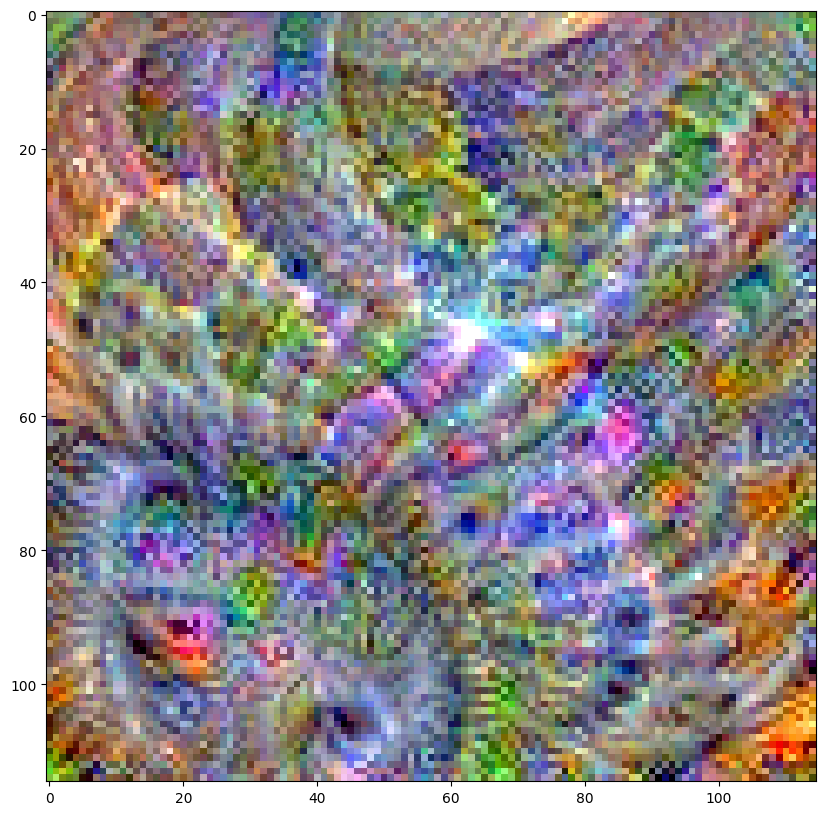

In [15]:
# And now we plot it
fig = plt.figure(figsize=(10,10))
plt.imshow(feature_map_48_91_img)

I do not know if you see the same thing that I did... Do you see some kind of snake?
We can check if the filter 91 at layer 48 is activated when the model receive a snake image as input.

# Let see the feature map generated by filter 91 at layer 48 using the image found

The image found was created by the FeatureMapVisualizer.
An interesting observation is that if we pay atention to the top predicted classes
of this image, we will know that this filter is a 'feature' related to other classes.
This image could be some kind of a cluster characteristic representation.
We could select the top 3 filters per layer (based on its activations) for 100
differents snakes and then check which are the filters that the snakes images have
in common and which are not. Based on this idea:
- We could detect common filters per class.
- We could detect related (different) classes based on common filters presented on them.
- We could define names for clusters of filters (some kind of language representation?)
- We could use this information to 'edit' a CNN to do other things.
If we want to create a model capable of distinguishing between just two classes.
i.e. frogs and cars, then we could discover in this networks that there are only 30
important filters that are activated with frogs and another 20 with cars, and then
use them to build a new model. Or may be we could discover that is better to use the
transfer learning technique to avoid wasting our time :D.

Top 10 predicted classes:
- sombrero: 8.2383650843326
- wool, woolen, woollen: 8.068540979357724
- coil, spiral, volute, whorl, helix: 7.602820216879644
- stole: 7.4452050226907796
- mask: 7.054290942868535
- spindle: 6.951305042319428
- confectionery, confectionary, candy store: 6.731262955073282
- bonnet, poke bonnet: 6.444639033308517
- maraca: 6.315089967826279
- poncho: 6.2001953063750666
torch.Size([14, 14])


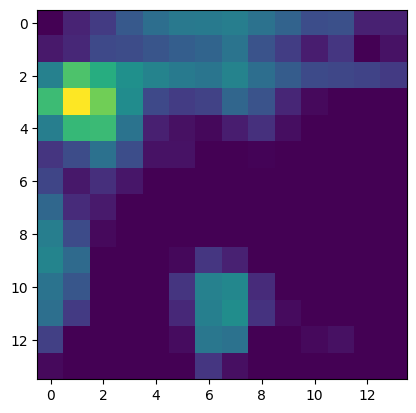

In [16]:
activation = SaveFeatures(layers[0][48], device=device)
# transform image to tensor and generate input for the model
input = img2tensor(PIL.Image.fromarray(np.uint8(feature_map_48_91_img*255))).unsqueeze(0).double()
output = model(input.to(device))
top(10, output, class_labels)
print(activation.features[0,91].shape)
plt.imshow(activation.features[0,91].clone().detach().cpu().numpy())
activation.close()
del activation

# Load an image

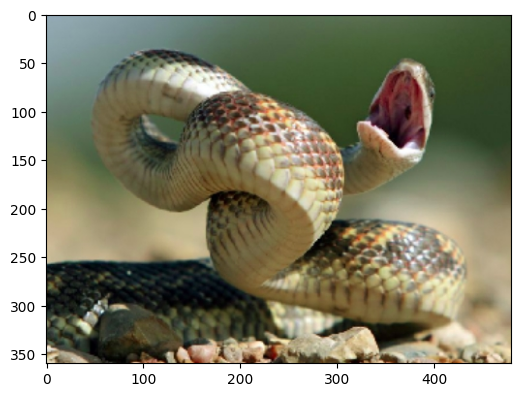

In [17]:
# load snake image
snake = PIL.Image.open('snake.jpg')
fig = plt.figure(figsize=(6,10))
plt.imshow(snake)
plt.show()

Top 10 predicted classes:
- sidewinder, horned rattlesnake, Crotalus cerastes: 18.034949617905408
- Indian cobra, Naja naja: 17.740912772115237
- night snake, Hypsiglena torquata: 17.45138522288921
- diamondback, diamondback rattlesnake, Crotalus adamanteus: 16.77788981074324
- horned viper, cerastes, sand viper, horned asp, Cerastes cornutus: 16.47826279327854
- thunder snake, worm snake, Carphophis amoenus: 16.283708892067867
- king snake, kingsnake: 16.106314811954327
- hognose snake, puff adder, sand viper: 16.08111175240406
- rock python, rock snake, Python sebae: 15.476126659463517
- sea snake: 15.18094793867635
torch.Size([14, 14])


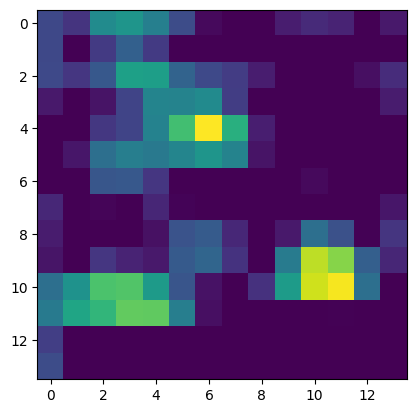

In [18]:
activation = SaveFeatures(layers[0][48], device=device)
# transform image to tensor and generate input for the model
input = img2tensor(snake).unsqueeze(0).double()
output = model(input.to(device))
top(10, output, class_labels)
print(activation.features[0,91].shape)
plt.imshow(activation.features[0,91].clone().detach().cpu().numpy())
activation.close()
del activation

# Obtain all filters activations of monitored layers

In [19]:
# transform image to tensor and generate input for the model
input = img2tensor(snake).unsqueeze(0).double()

In [20]:
# get activations 
mean_acts = fmv.get_activations(monitor, input)

hooking layers [2, 5, 9, 12, 16, 19, 22, 25, 29, 32, 35, 38, 42, 45, 48, 51]


unhooking layers.


# Plot all filters activated values
1. Plot all feature maps mean values per layer (highlight top 3 activations)

Generating visualization for filters activations per layer................tight_layout...


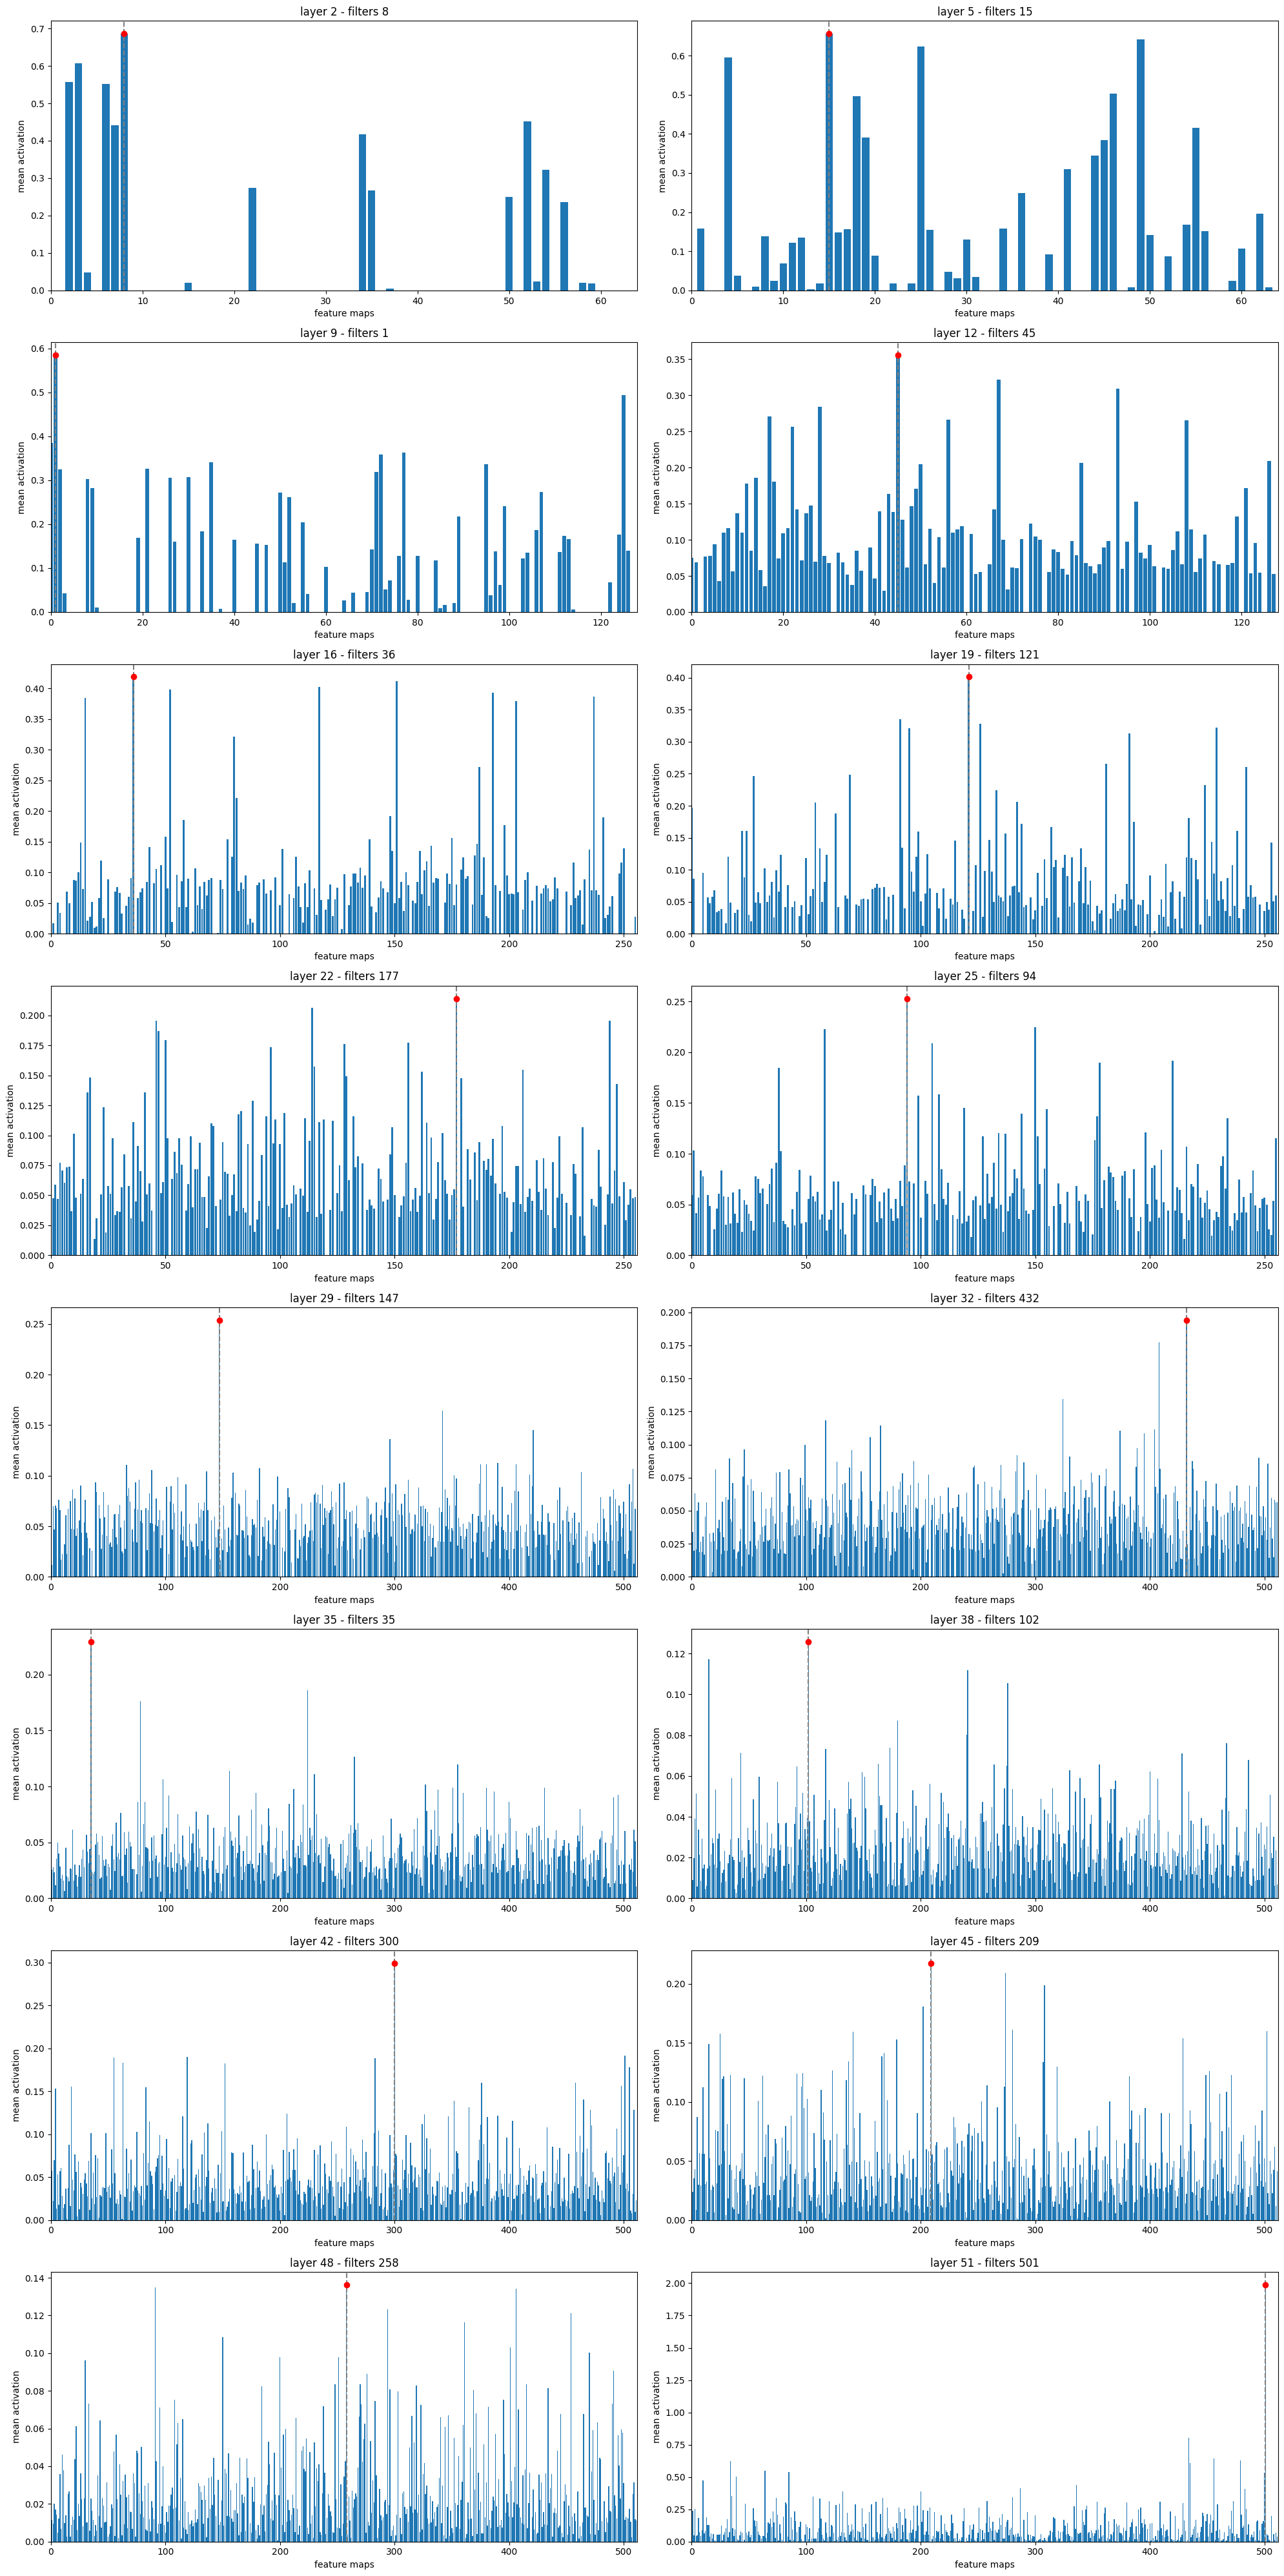

In [21]:
top_filters = {}
n = len(mean_acts)
# we are monitoring 16 layers
rows, cols = 8,2
fig = plt.figure(figsize=(cols*10, rows*5))
print('Generating visualization for filters activations per layer', end='')
for i,k in enumerate(mean_acts.keys()):
    print('.', end='')
    ax = plt.subplot(rows, cols, i+1)
    top_filters[k] = sorted(range(len(mean_acts[k])), key=lambda idx: mean_acts[k][idx], reverse=True)[:TOP]
    for filter in top_filters[k]:
        plt.axvline(x=filter, color='grey', linestyle='--')
    act = plt.bar(list(range(len(mean_acts[k]))), mean_acts[k])
    ax = act[0].axes
    ax.set_xlim(0,len(mean_acts[k]))
    ax.plot(top_filters[k], [mean_acts[k][f] for f in top_filters[k]], 'ro')
    ax.set_xlabel("feature maps")
    ax.set_ylabel("mean activation")
    f_desc = ''
    for f in top_filters[k]:
        f_desc += ' ' + str(f)
    ax.set_title('layer {} - filters{}'.format(k, f_desc))
print('tight_layout...')
plt.tight_layout()
fig.savefig(images_dir + 'top_3_activated_filters_per_layer.jpg')

We can see at layer 48 that the best mean activations is generated by filter 91

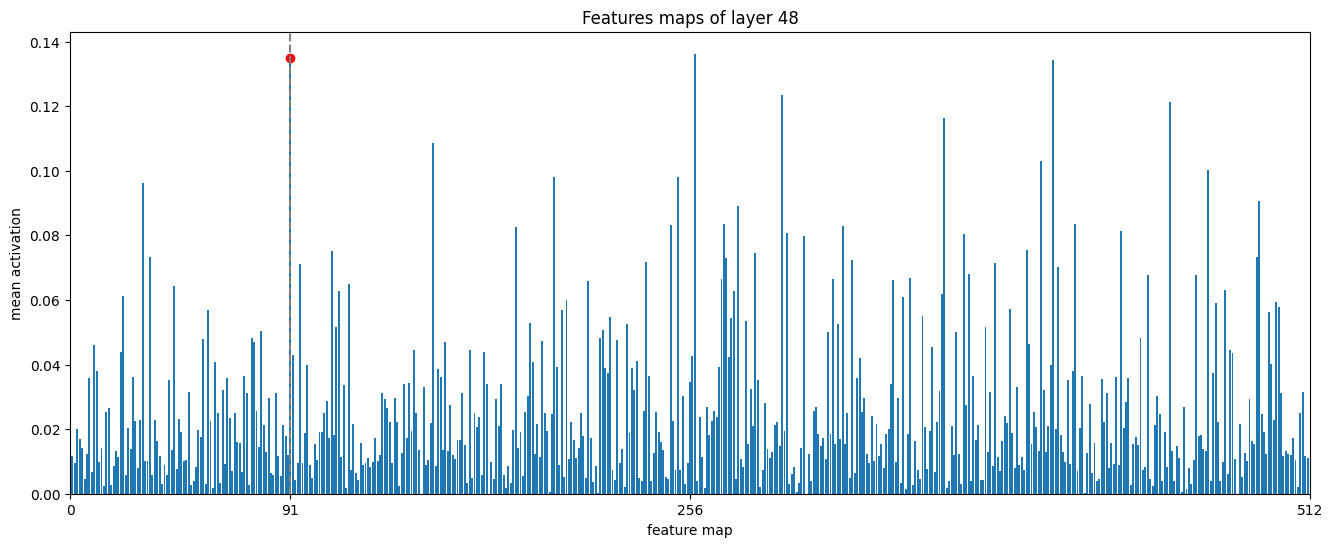

In [22]:
# Let plot it with zoom
show_filters(mean_acts[48], 91, '48')

# Generate 3 input images for the top 3 activated filters
This is done per layer

In [23]:
fms = {}
fmv = FeatureMapVisualizer(model, device, layers_base=layers[0], save=save)
for layer in top_filters.keys():
    filters = top_filters[layer]
    fms[layer] = []
    for filter in filters:
        fms[layer].append(fmv.visualize(
            layer=layer, filter=filter,
            size=56, upscaling_steps=upscaling_steps, upscaling_factor=1.2,
            lr=0.1, opt_steps=opt_steps, blur=3, verbose=verbose))
        

Processing filter 8...
 56 x  56.

.........
 67 x  67..........
preparing image...
Processing filter 15...
 56 x  56..........
 67 x  67..........
preparing image...
Processing filter 1...
 56 x  56..........
 67 x  67..........
preparing image...
Processing filter 45...
 56 x  56..........
 67 x  67..........
preparing image...
Processing filter 36...
 56 x  56..........
 67 x  67..........
preparing image...
Processing filter 121...
 56 x  56..........
 67 x  67..........
preparing image...
Processing filter 177...
 56 x  56..........
 67 x  67..........
preparing image...
Processing filter 94...
 56 x  56..........
 67 x  67..........
preparing image...
Processing filter 147...
 56 x  56..........
 67 x  67..........
preparing image...
Processing filter 432...
 56 x  56..........
 67 x  67..........
preparing image...
Processing filter 35...
 56 x  56..........
 67 x  67..........
preparing image...
Processing filter 102...
 56 x  56..........
 67 x  67..........
preparing image...
Processing filter 300...
 56 x  56

# Visualize generated input images

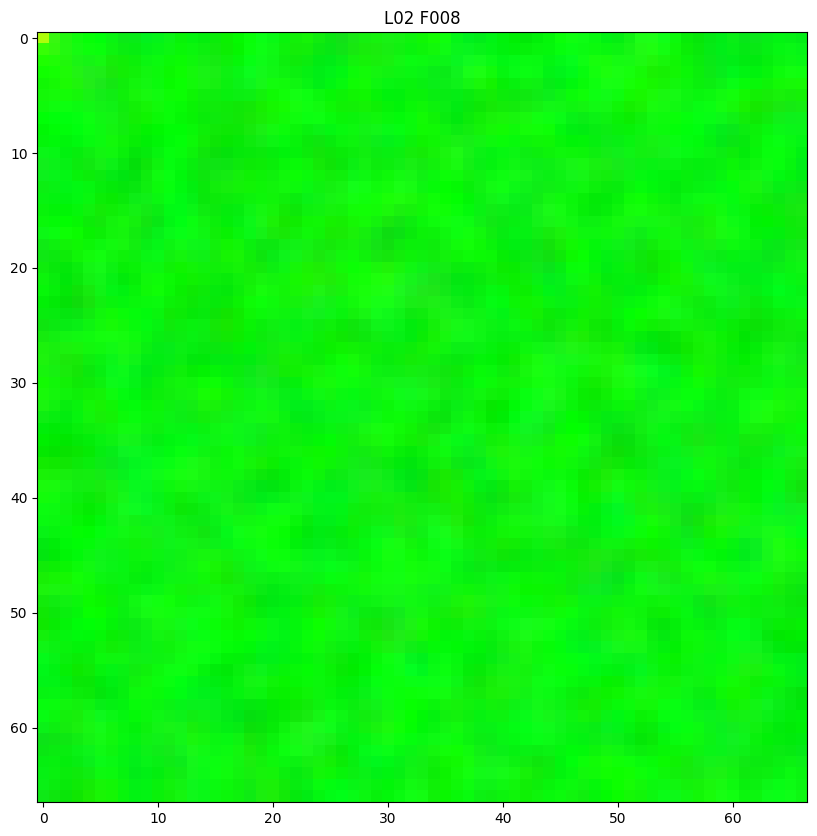

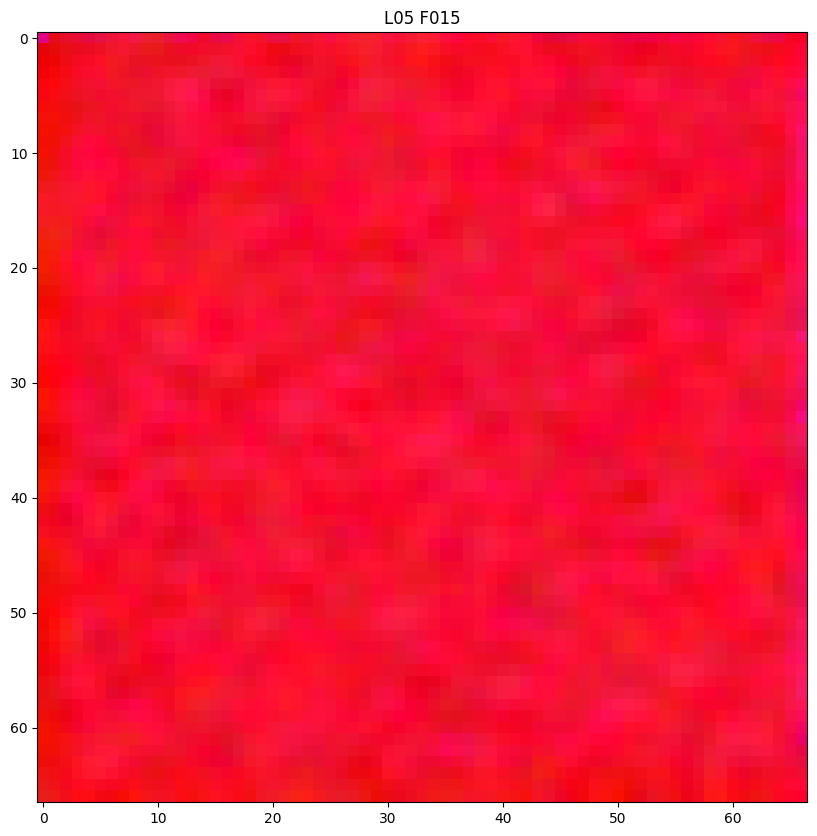

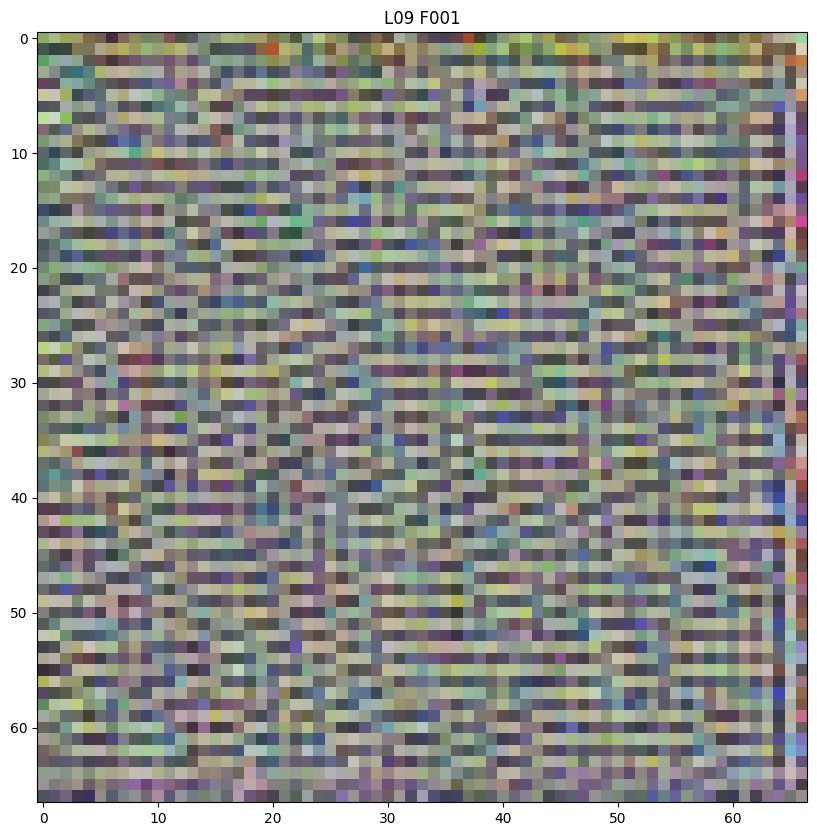

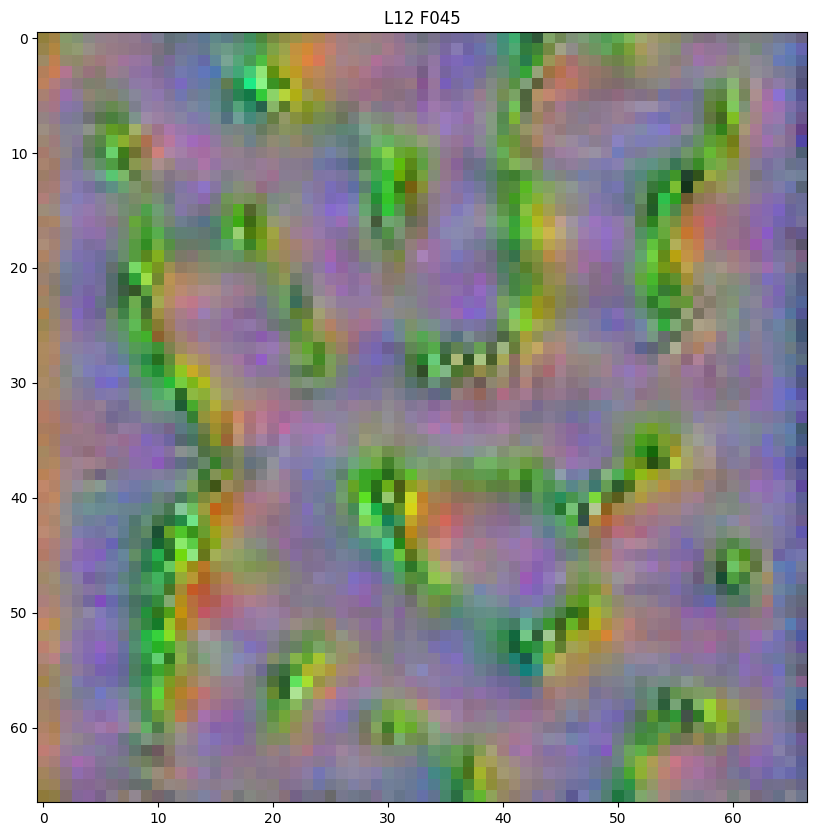

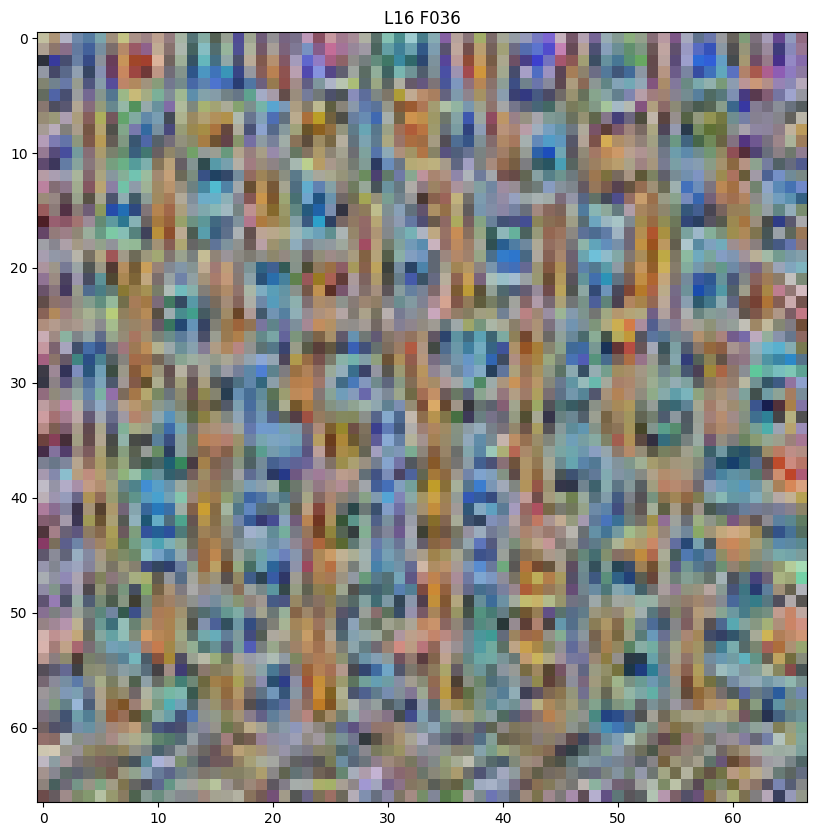

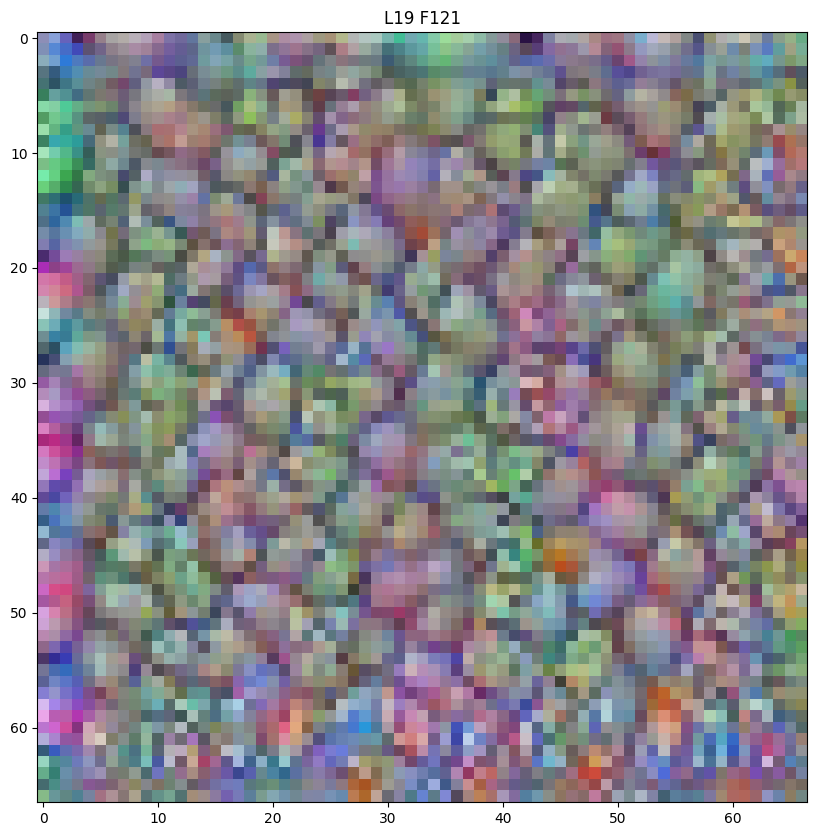

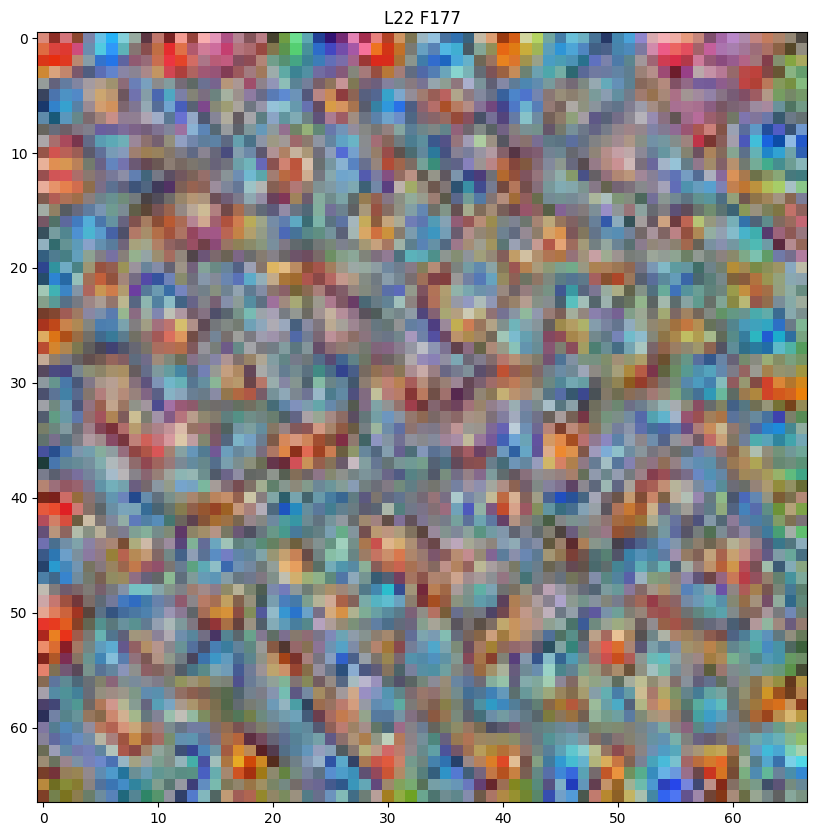

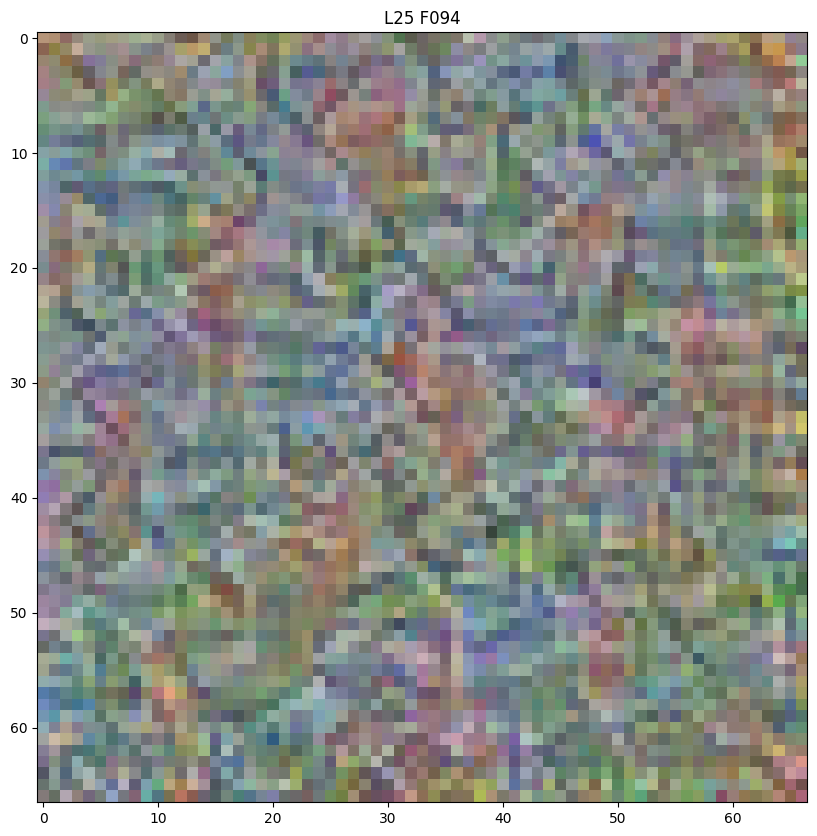

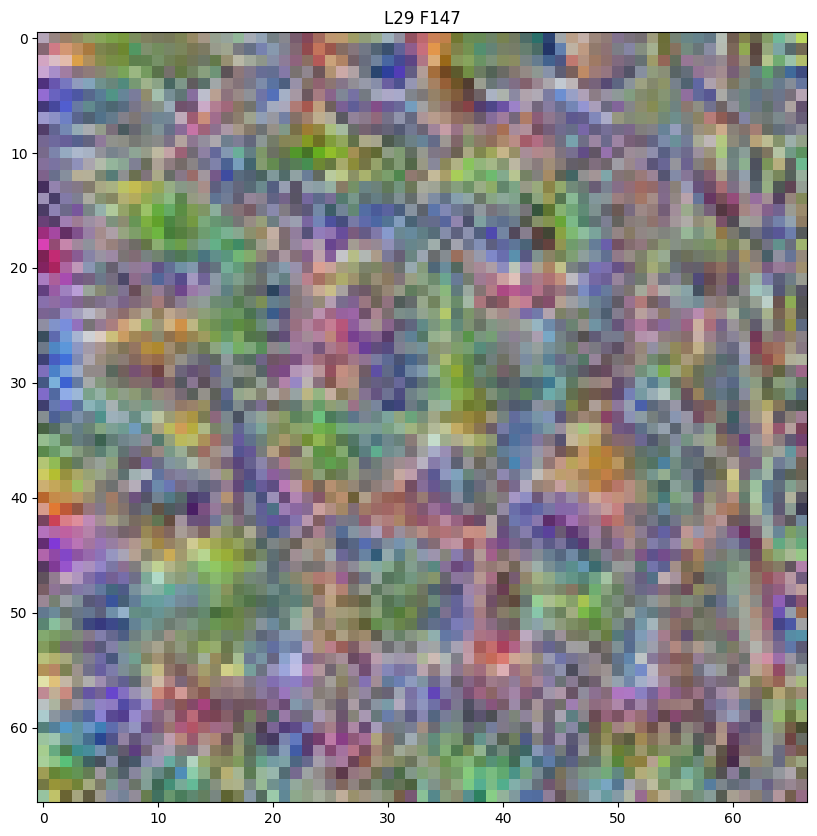

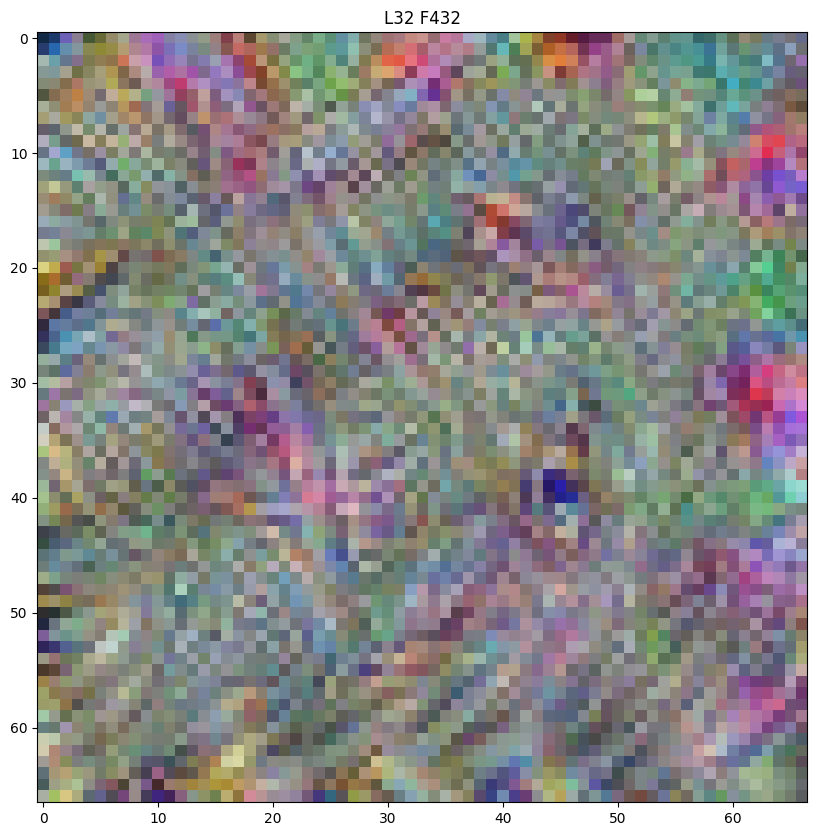

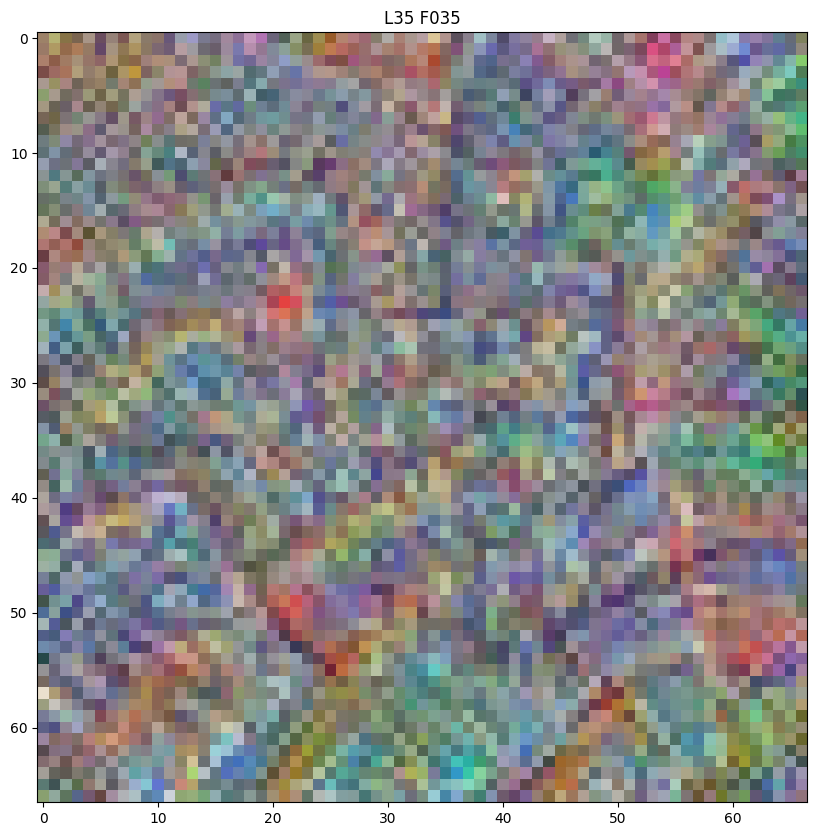

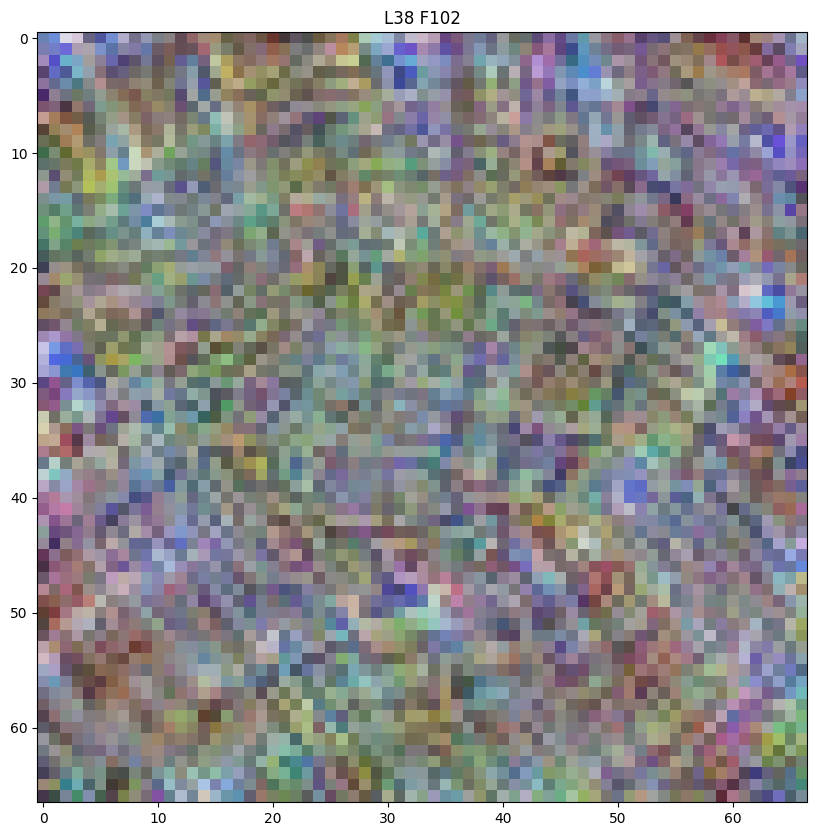

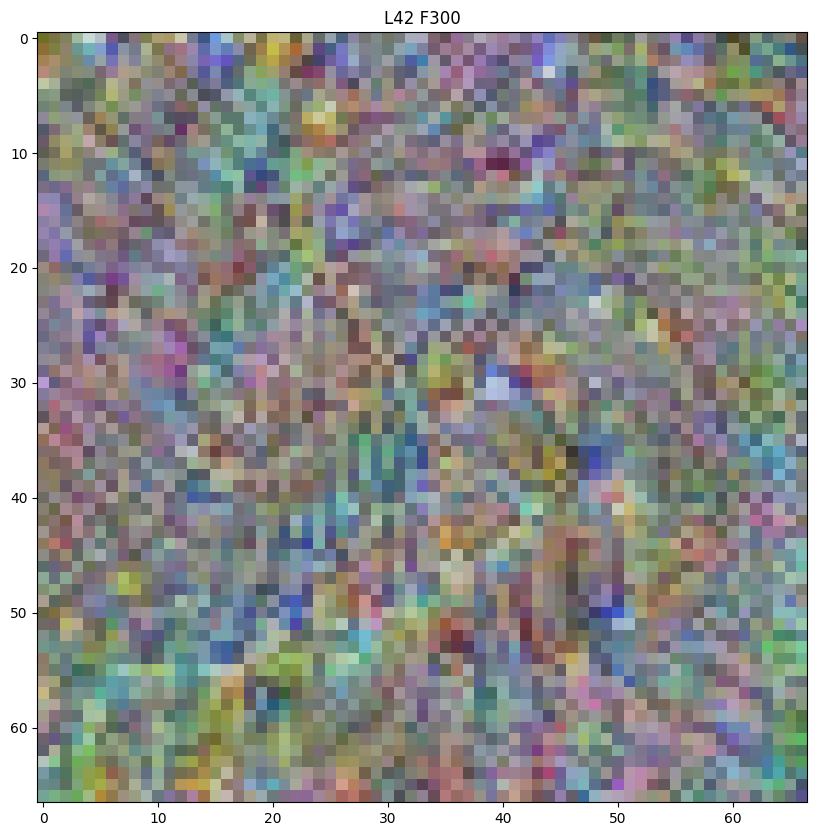

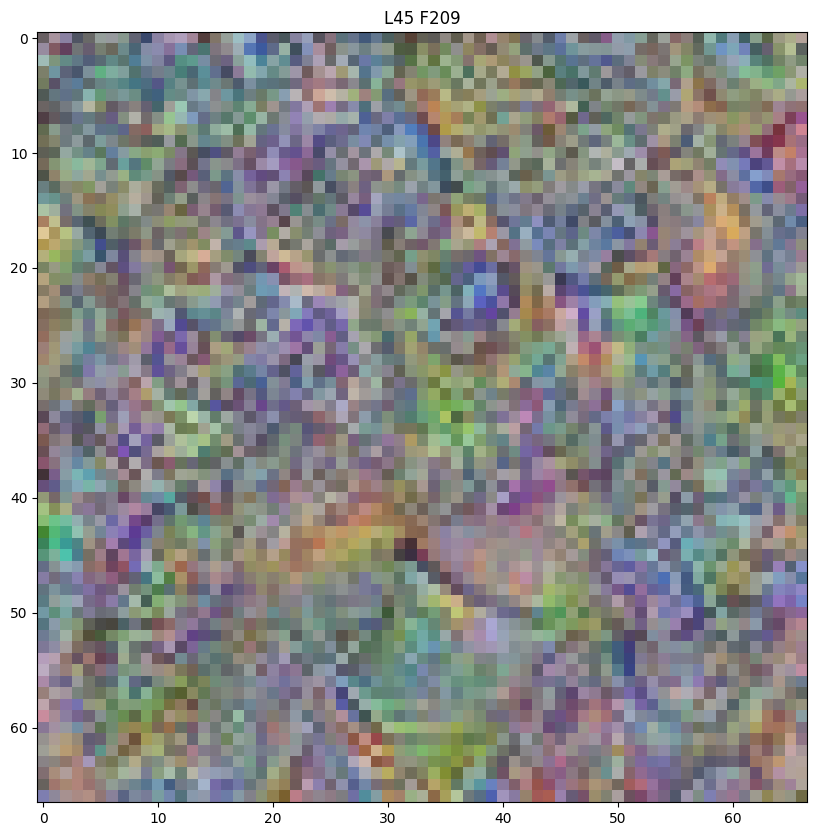

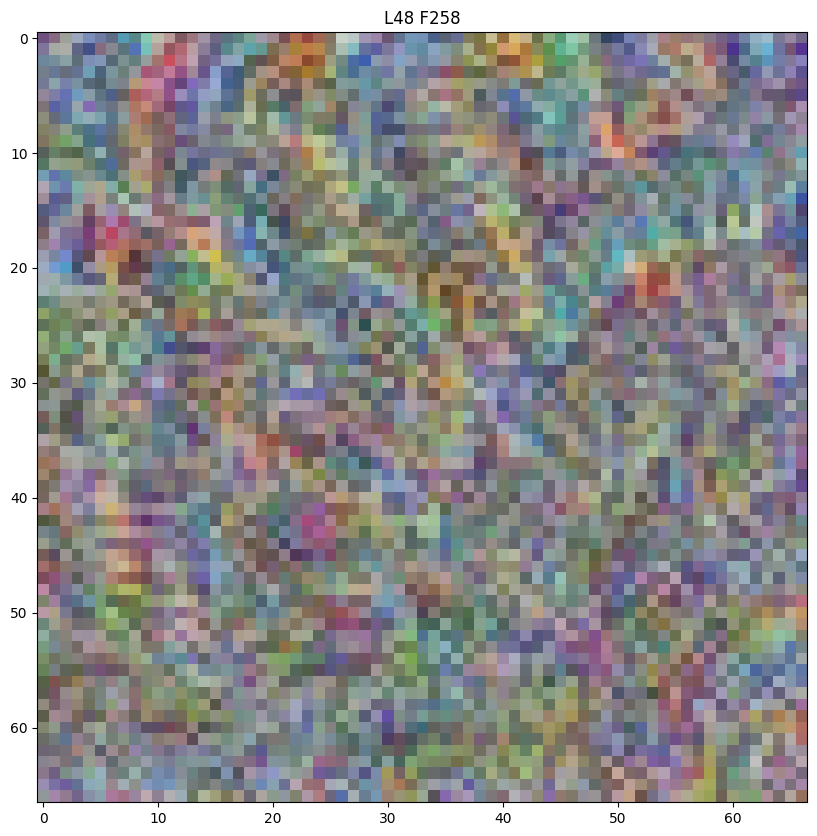

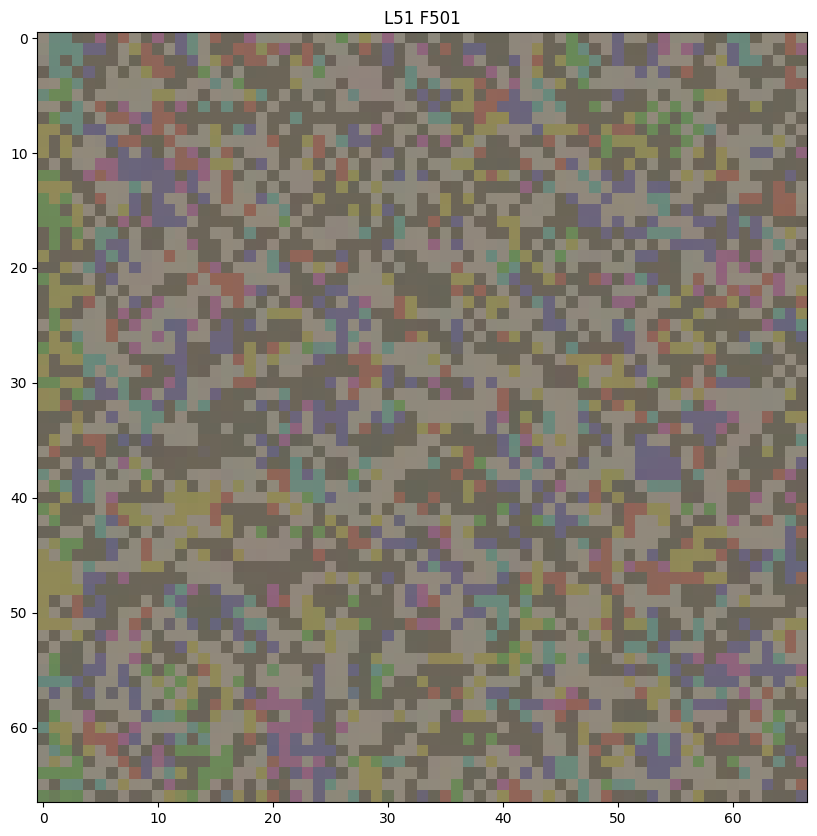

In [24]:
for layer in fms.keys():
    filters = top_filters[layer]
    fig = plt.figure(figsize=(20,10))    
    for i in range(len(filters)):
        ax = plt.subplot(1,len(filters), i+1)
        ax.imshow(fms[layer][i])
        ax.set_title('L{:02d} F{:03d}'.format(layer, filters[i]))
    plt.show()
        

# Save the generated images in one zip file

In [25]:
def zip_images(name):
    ziph = zipfile.ZipFile('{}.zip'.format(name), 'w', zipfile.ZIP_DEFLATED)
    # ziph is zipfile handle
    for root, dirs, files in os.walk('./images/'):
        for file in files:
            ziph.write(os.path.join(root, file))
    ziph.close()

In [26]:
zip_images('snake_feature_maps')

In [27]:
# remove all image files
!rm ./images/*.*
!rmdir ./images/ 